In [1]:
##import packages
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
import subprocess
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
import os

warnings.filterwarnings('ignore')
import time
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats

from scipy.spatial.distance import cdist
import h5py

import anndata
import torch
import sys


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
matplotlib.rcParams['figure.dpi'] = 150


First, you must download the scRNA count file and
Put the scRNA count file in :

'FigureData/Figure4/Dataset4_seqFISH+/Rawdata/' and 
'FigureData/Figure4/Dataset4_STARmap/Rawdata/'

The scRNA count link:
https://drive.google.com/file/d/1ugoZtGHwoK6CLGVK4kWehLscqJqNNha4/view?usp=sharing

# 1. Part1 : grid spots with different pixes

In [3]:
### please the vefity that you have installed the Seurat,SpaOTsc,Tangram,novoSpaRc
### please  make sure you are in SpatialBenmarking dir and have prepared the data files
def Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateXlable, CoordinateYlable, window, outdir):
    if os.path.exists(outdir):
        print ('The output file is in ' + outdir)
    else:
        os.mkdir(outdir)
    combined_spot = []
    combined_spot_loc = []
    window=window
    c = 0
    for x in np.arange((spatial_loc[CoordinateXlable].min()//window),spatial_loc[CoordinateXlable].max()//window+1):
        for y in np.arange((spatial_loc[CoordinateYlable].min()//window),spatial_loc[CoordinateYlable].max()//window+1):
            tmp_loc = spatial_loc[(x*window < spatial_loc[CoordinateXlable]) & (spatial_loc[CoordinateXlable] < (x+1)*window) & (y*window < spatial_loc[CoordinateYlable]) & (spatial_loc[CoordinateYlable] < (y+1)*window)]
            if len(tmp_loc) > 0:
                c += 1
                combined_spot_loc.append([x,y])
                combined_spot.append(tmp_loc.index.to_list())
            
    combined_cell_counts = pd.DataFrame([len(s) for s in combined_spot],columns=['cell_count'])
    combined_cell_counts.to_csv(outdir + '/combined_cell_counts.txt',sep='\t')
    combined_cell_counts = pd.read_csv(outdir + '/combined_cell_counts.txt',sep='\t',index_col=0)
    print ('The simulated spot has cells with ' + str(combined_cell_counts.min()[0]) + ' to ' + str(combined_cell_counts.max()[0]))
    combined_spot_loc = pd.DataFrame(combined_spot_loc, columns=['x','y'])
    combined_spot_loc.to_csv(outdir + '/combined_Locations.txt',sep='\t',index=False)


    combined_spot_exp = []
    for s in combined_spot:
        combined_spot_exp.append(spatial_rna.loc[s,:].sum(axis=0).values)
    combined_spot_exp = pd.DataFrame(combined_spot_exp, columns=spatial_rna.columns)
    combined_spot_exp.to_csv(outdir + '/combined_spatial_count.txt',sep='\t',index=False)

    combined_spot_clusters = pd.DataFrame(np.zeros((len(combined_spot_loc.index),len(np.unique(spatial_meta['celltype'])))),columns=np.unique(spatial_meta['celltype']))
    for i,c in enumerate(combined_spot):
        for clt in spatial_meta.loc[c,'celltype']:
            combined_spot_clusters.loc[i,clt] += 1
    combined_spot_clusters.to_csv(outdir + '/combined_spot_clusters.txt',sep='\t')
    print ('The simulated spot has size ' + str(combined_spot_clusters.shape[0]))


# seqFISH+ dataset simulated with 500 pixes

In [4]:
###before you simulated data, please check your cluster name and verfity that the cluster name in both data are same.
###please note that the cluster labels do not contain '/' or ' ' or '&'
time_start=time.time()
PATH = 'FigureData/Figure4/Dataset4_seqFISH+/'

sc_rna = pd.read_csv(PATH + 'Rawdata/scRNA_count.txt', sep='\t',index_col=0, engine='c',low_memory=False)
spatial_rna = pd.read_csv(PATH + 'Rawdata/Spatial_count.txt',sep='\t')
spatial_rna = spatial_rna.loc[:,spatial_rna.columns[spatial_rna.columns.isin(sc_rna.index)]]

spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt', sep = '\t', index_col=0)
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations_seqfish.txt',sep='\t')

window = 500
CoordinateX = 'X'
CoordinateY = 'Y'
outdir = PATH + 'Simulated_seqFISH+/'

Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateX, CoordinateY, window, outdir) 
time_end=time.time()
print('seqFISH+ dataset simulated step costs',time_end-time_start,'s')

The output file is in FigureData/Figure4/Dataset4_seqFISH+/Simulated_seqFISH+/
The simulated spot has cells with 1 to 17
The simulated spot has size 72
seqFISH+ dataset simulated step costs 44.611178398132324 s


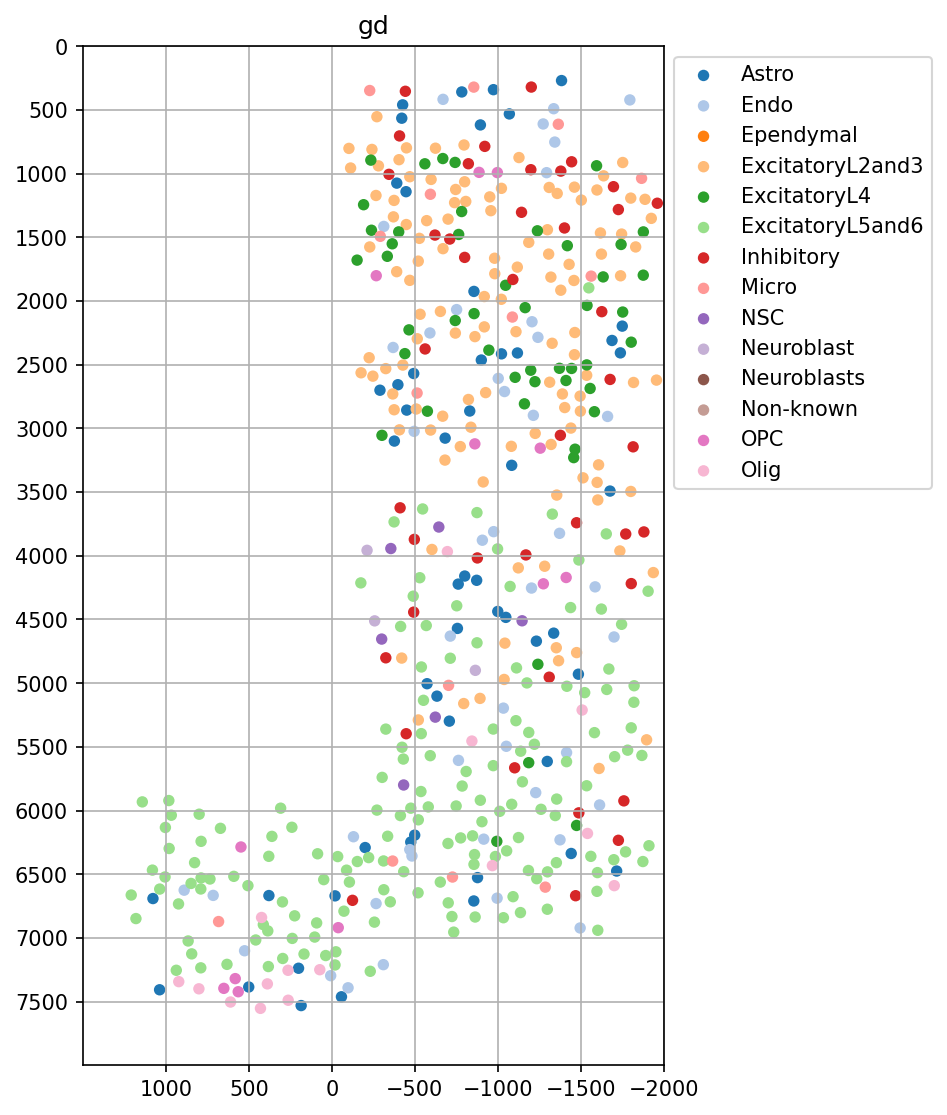

In [5]:
###plot the simulated data image
spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt',sep='\t')
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations_seqfish.txt',sep='\t')
fig,ax = plt.subplots(figsize=(5,9))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(np.array(spatial_meta.celltype))))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['Y'][:-1],y=spatial_loc[spatial_meta['celltype'] == c]['X'][:-1],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(-2000,1500,500))
plt.yticks(np.arange(0,8000,500))
plt.xlim(-2000,1500)
plt.ylim(0,8000)
ax.invert_yaxis()
ax.invert_xaxis()
plt.grid()
plt.show()


# STARmap dataset simulated with 750 pixes

In [5]:
time_start=time.time()
PATH = 'FigureData/Figure4/Dataset7_STARmap/'
sc_rna = pd.read_csv(PATH + 'Rawdata/scRNA_count.txt', sep='\t',index_col=0,engine='c',low_memory=False)
spatial_rna = pd.read_csv(PATH + 'Rawdata/Spatial_count.txt',sep='\t')
spatial_rna = spatial_rna.loc[:,spatial_rna.columns[spatial_rna.columns.isin(sc_rna.index)]]
spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt',sep='\t',index_col=0)
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations.txt',sep='\t')

window = 750
CoordinateX = 'X'
CoordinateY = 'Y'
outdir = PATH + 'Simulated_STARmap/'

Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateX, CoordinateY, window, outdir) 
time_end=time.time()
print('STARmap dataset simulated step costs',time_end-time_start,'s')

The output file is in FigureData/Figure4/Dataset7_STARmap/Simulated_STARmap/
The simulated spot has cells with 1 to 17
The simulated spot has size 189
STARmap dataset simulated step costs 82.68872022628784 s


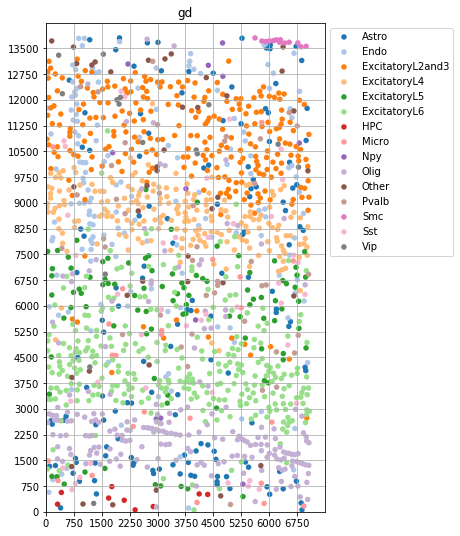

In [6]:

spatial_meta = pd.read_csv(PATH + 'Rawdata/Spatial_annotate.txt',sep='\t')
spatial_loc = pd.read_csv(PATH + 'Rawdata/Locations.txt',sep='\t')
fig,ax = plt.subplots(figsize=(5,9))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(spatial_meta.celltype)))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['X'],y=spatial_loc[spatial_meta['celltype'] == c]['Y'],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(0,7500,750))
plt.yticks(np.arange(0,14250,750))
plt.xlim(0,7500)
plt.ylim(0,14250)
plt.grid()
plt.show()
